In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.neural_network import MLPRegressor
from tabulate import tabulate
from transformers import pipeline

bos_path = kagglehub.dataset_download("airbnb/boston")
sea_path = kagglehub.dataset_download("airbnb/seattle")

### What city is more expensive?

In [3]:
bos_cal = pd.read_csv(f'{bos_path}/calendar.csv')
sea_cal = pd.read_csv(f'{sea_path}/calendar.csv')

In [4]:
def parse_price(df):
    """Clean 'price' column by dropping NA values and parsing str to float."""
    df = df.dropna(subset=['price'])
     # TODO: replace df['price'] with df.loc[:, 'price'] (type conversion does not work atm)
    df['price'] = df.price.replace(r'[\$,]', '', regex=True).astype(float)
    return df

bos_cal_clean = parse_price(bos_cal)
sea_cal_clean = parse_price(sea_cal)

bos_cal_clean.head()

,listing_id,date,available,price
365,3075044,2017-08-22,t,65.0
366,3075044,2017-08-21,t,65.0
367,3075044,2017-08-20,t,65.0
368,3075044,2017-08-19,t,75.0
369,3075044,2017-08-18,t,75.0


In [5]:
# average daily price
print(f'average daily price\nBoston: ${bos_cal_clean.price.mean():.2f}\nSeattle: ${sea_cal_clean.price.mean():.2f}')

average daily price
Boston: $198.44
Seattle: $137.94


In [6]:
def price_avg_by_listing(df):
    """Average daily price per listing."""
    df = df.drop(columns=['date', 'available'])
    return df.groupby('listing_id').agg('mean').sort_values('listing_id')

bos_cal_avg_lst = price_avg_by_listing(bos_cal_clean)
sea_cal_avg_lst = price_avg_by_listing(sea_cal_clean)

bos_cal_avg_lst.head()

,price
listing_id,
3353,35.204819
5506,147.267442
6695,197.407407
6976,65.000000
8792,154.000000


In [7]:
# average listing price
print(f'average listing price\nBoston: ${bos_cal_avg_lst.values.mean():.2f}\nSeattle: ${sea_cal_avg_lst.values.mean():.2f}')

average listing price
Boston: $196.94
Seattle: $135.76


In [8]:
def price_avg_by_date(df):
    """Average daily price per month."""
    df.loc[:, 'date'] = df.date.apply(lambda d: '-'.join(d.split('-')[:-1]))
    df = df.drop(columns=['listing_id', 'available'])
    return df.groupby('date').agg('mean').sort_values('date')

bos_cal_avg_date = price_avg_by_date(bos_cal_clean)
sea_cal_avg_date = price_avg_by_date(sea_cal_clean)

bos_cal_avg_date.head()

,price
date,
2016-09,252.677308
2016-10,233.416248
2016-11,202.924416
2016-12,192.601915
2017-01,182.799671


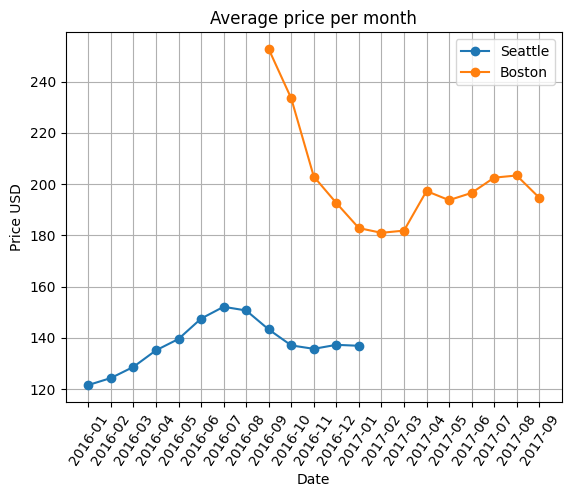

In [9]:
# plot date vs price
plt.plot(sea_cal_avg_date.index, sea_cal_avg_date.values, marker='o', linestyle='-', label='Seattle')
plt.plot(bos_cal_avg_date.index, bos_cal_avg_date.values, marker='o', linestyle='-', label='Boston')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.grid(True)
plt.xticks(rotation=56.25)
plt.title('Average price per month')
plt.legend()
plt.show()

### Are there any features in listings that help predict price?

In [10]:
bos_lst = parse_price(pd.read_csv(f'{bos_path}/listings.csv'))
sea_lst = pd.read_csv(f'{sea_path}/listings.csv')

bos_lst.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [11]:
feat = [
    'city', 'neighbourhood_cleansed', # location
    'room_type', 'property_type',
    'accommodates', 'bathrooms', 'bedrooms', # size of the property
    'amenities',
    'number_of_reviews', 'review_scores_rating', 'review_scores_location',
    'price',
]

def preprocess(df):
    """
    Prepare reviews dataset by dropping null values
    and creating dummy variables for categorical columns.
    """
    new_df = df[feat].dropna()
    new_df = parse_price(new_df)

    new_df.loc[:, 'city'] = new_df.city.map(lambda c: c.strip().title())
    new_df.loc[:, 'amenities'] = new_df.amenities.replace(r'[\{\}]', '', regex=True)
    new_df.loc[:, 'number_of_amenities'] = new_df.amenities.str.split(',').map(len)

    new_df.loc[:, 'review_scores_rating'] = new_df.review_scores_rating * \
        new_df.number_of_reviews.map(lambda n: 1 if n == 0 else np.log(n) + 1)
    new_df = new_df.drop(columns=['number_of_reviews'])

    amenities_dummy = new_df.amenities.replace(r'.*\bmissing\b.*', '', regex=True) \
        .str.get_dummies(sep=',').add_prefix('amenities_').astype('uint8')

    new_df_dummy = pd.get_dummies(new_df.drop(columns=['amenities']), dtype=np.uint8)
    new_df = pd.concat([new_df_dummy, amenities_dummy], axis=1)
    return new_df

def eval_model(df):
    """
    Split dataset, train and run model, and report metrics (R-squared and RMSE).
    """
    X = df.loc[:, df.columns != 'price']
    y = df.loc[:, 'price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=24)

    model = MLPRegressor()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_r2_score = r2_score(y_train, y_train_pred)
    train_mse = root_mean_squared_error(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_r2_score = r2_score(y_test, y_test_pred)
    test_mse = root_mean_squared_error(y_test, y_test_pred)

    print(tabulate([
        ['', 'R-squared', 'RMSE'],
        ['Train', train_r2_score, train_mse],
        ['Test', test_r2_score, test_mse],
    ], headers='firstrow'))
    print(f'\nprice range: {y.min()}-{y.max()}')

In [ ]:
bos_lst.loc[:, 'city'] = bos_lst.city.mode()[0]
sea_lst.loc[:, 'city'] = sea_lst.city.mode()[0]

lst_ft = preprocess(pd.concat([bos_lst, sea_lst]))

lst_ft.head()

,accommodates,bathrooms,bedrooms,review_scores_rating,review_scores_location,price,number_of_amenities,city_Boston,city_Seattle,neighbourhood_cleansed_Adams,...,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer
1,2,1.0,1.0,430.850780,9.0,65.0,21,1,0,0,...,0,1,1,1,1,1,0,1,1,1
2,2,1.0,1.0,461.930063,9.0,65.0,18,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,1.0,100.000000,10.0,75.0,23,1,0,0,...,1,1,1,1,1,1,0,1,1,1
4,2,1.5,1.0,432.362287,9.0,79.0,14,1,0,0,...,0,1,1,1,1,1,0,1,0,0
5,2,1.0,1.0,307.944154,9.0,75.0,13,1,0,0,...,0,1,1,0,1,1,0,0,0,0


In [13]:
eval_model(lst_ft)

         R-squared     RMSE
-----  -----------  -------
Train     0.666176  60.38
Test      0.624152  62.0126

price range: 11.0-1300.0


### Which reviews are positive and which ones are negative?

In [14]:
bos_rev = pd.read_csv(f'{bos_path}/reviews.csv')
sea_rev = pd.read_csv(f'{sea_path}/reviews.csv')

bos_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [15]:
def get_torch_device():
    """Fetch host-available torch device."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

def add_scores(df):
    """Add review scores to dataframe."""
    review_analyzer = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment",
        device=get_torch_device(),
    )
    notna = df.comments.notna()
    df.loc[:, 'scores'] = df.comments
    df.loc[notna, 'scores'] = review_analyzer(
        df.loc[notna, 'scores'].tolist(),
        truncation=True,
    )
    return df

def get_scores_df(df, fpath):
    """Add review scores to dataframe and save it to csv.
    If the csv file already exists, read it into dataframe."""
    if not os.path.exists(fpath):
        score_df = add_scores(df)
        fpath = Path(fpath)
        fpath.parent.mkdir(parents=True, exist_ok=True)
        score_df.to_csv(fpath, index=False)
    else:
        score_df = pd.read_csv(fpath)
    return score_df

In [16]:
bos_rev_scores = get_scores_df(bos_rev, 'out/boston/reviews_scores.csv')
sea_rev_scores = get_scores_df(sea_rev, 'out/seattle/reviews_scores.csv')

bos_rev_scores.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,scores
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,"{'label': '5 stars', 'score': 0.652658998966217}"
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,"{'label': '5 stars', 'score': 0.577445387840271}"
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,"{'label': '4 stars', 'score': 0.8463928699493408}"
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,"{'label': '4 stars', 'score': 0.4779614210128784}"
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,"{'label': '5 stars', 'score': 0.5849300622940063}"
